# Import the package

In [1]:
from datetime import datetime
import lightgbm as lgb
from lightgbm import LGBMClassifier
from lightgbm import plot_importance
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline
import numpy as np
from numpy import mean
from numpy import std
from numpy import sort
import pandas as pd
from pandas.core.frame import DataFrame
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
from sklearn.metrics import f1_score  
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix,roc_curve,roc_auc_score,accuracy_score, plot_confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import log_loss
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper,DeltaYStopper
from skopt.space import Real,Categorical,Integer
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE

import joblib
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

# Dataset

## Original dataset

In [2]:
CTGData=pd.read_csv('CTG.csv')

In [3]:
CTGData3=CTGData.copy()
X=CTGData3.drop(labels=['CLASS','NSP'],axis=1)

y=CTGData3['NSP'].values
y = LabelEncoder().fit_transform(y)

In [4]:
CTGData3.shape

(2126, 23)

In [5]:
#stanardilization
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(X)
X=scaler.transform(X)

In [6]:
#split train dataset and test dataset
X_train, X_test,y_train,y_test= train_test_split(X,y,test_size=0.2,random_state=42)



## Selected feature

In [7]:
features20=pd.read_csv('CTGNSP selected 20 features.csv')
# ,index_col=0)
features20.head()

,LB,AC,FM,UC,DL,DP,ASTV,MSTV,ALTV,MLTV,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,label
0,120,0.000000,0.0,0.000000,0.000000,0.0,73,0.5,43,2.4,...,62,126,2,0,120,137,121,73,1,1
1,132,0.006380,0.0,0.006380,0.003190,0.0,17,2.1,0,10.4,...,68,198,6,1,141,136,140,12,0,0
2,133,0.003322,0.0,0.008306,0.003322,0.0,16,2.1,0,13.4,...,68,198,5,1,141,135,138,13,0,0
3,134,0.002561,0.0,0.007682,0.002561,0.0,16,2.4,0,23.0,...,53,170,11,0,137,134,137,13,1,0
4,132,0.006515,0.0,0.008143,0.000000,0.0,16,2.4,0,19.9,...,53,170,9,0,137,136,138,11,1,0


In [8]:
features20.shape

(2126, 21)

In [9]:
X1=features20.drop(labels=['label'],axis=1)

y1=features20['label'].values


In [10]:
scaler=StandardScaler()
scaler.fit(X1)
X1=scaler.transform(X1)
#split train dataset and test dataset
X1_train, X1_test,y1_train,y1_test= train_test_split(X1,y1,test_size=0.2, shuffle = True,stratify=y1,random_state=42)

# Model

## Light GBM

In [11]:
lgbm1=LGBMClassifier(boosting_type='gbdt',objective ='multiclass',
                                 max_depth=8, num_leaves=170,
                                learning_rate=0.01,n_estimators=300,
                                colsample_bytree= 0.8,subsample= 0.8)

In [12]:
lgbm_ctgnsp=lgbm1.fit(X1_train,y1_train)

In [13]:
y_pred_lgbm1=lgbm1.predict((X1_test))
y_prob_lgbm1=lgbm1.predict_proba((X1_test))
print("Accuracy score with LGBM is: ",accuracy_score(y1_test, y_pred_lgbm1))
print("F1 score with LGBM is: ",f1_score(y1_test, y_pred_lgbm1,average='micro'))
print("ROC_AUC score with LGBM is: ", roc_auc_score(y1_test,y_prob_lgbm1,multi_class='ovr',labels=np.unique(y1_test)))
print("Cross entropy loss score with LGBM is: ",log_loss(y1_test,y_prob_lgbm1))


Accuracy score with LGBM is:  0.931924882629108
F1 score with LGBM is:  0.931924882629108
ROC_AUC score with LGBM is:  0.9824944554519801
Cross entropy loss score with LGBM is:  0.1832007685672168


In [14]:
lgbm_accuracy='%.4f'%accuracy_score(y1_test, y_pred_lgbm1)
lgbm_f1='%.4f'%f1_score(y1_test, y_pred_lgbm1,average='micro')
lgbm_roc_auc='%.4f'% roc_auc_score(y1_test,y_prob_lgbm1,multi_class='ovr',labels=np.unique(y1_test))
lgbm_loss='%.4f'%log_loss(y1_test,y_prob_lgbm1)
print(lgbm_accuracy)
print(lgbm_f1)
print(lgbm_roc_auc)
print(lgbm_loss)

0.9319
0.9319
0.9825
0.1832


In [15]:
start=datetime.now()
accuracy_score_20 =cross_val_score(lgbm1, X1_train, y1_train, cv=5,scoring='accuracy').mean()
F1_score_20 =cross_val_score(lgbm1, X1_train, y1_train, cv=5,scoring='f1_micro').mean()
roc_auc_score_20 =cross_val_score(lgbm1, X1_train, y1_train, cv=5,scoring='roc_auc_ovr').mean()
neg_loss_score_20 =cross_val_score(lgbm1, X1_train, y1_train, cv=5,scoring='neg_log_loss').mean()
stop=datetime.now()

execution_time_lgbm4=(stop-start)/20
execution_time_lgbm4

print("accuracy 20  feature:",accuracy_score_20)
print('F1 score 20  feature:',F1_score_20)
print('roc_auc 20  feature:',roc_auc_score_20)
print("cross entropy loss 20  feature:",neg_loss_score_20)


accuracy 20  feature: 0.9488235294117647
F1 score 20  feature: 0.9488235294117647
roc_auc 20  feature: 0.9872886454457237
cross entropy loss 20  feature: -0.14793525408062694


In [16]:
execution_time_lgbm4

datetime.timedelta(microseconds=625763)

In [17]:
training_time_lgbm=execution_time_lgbm4.total_seconds()
training_time_lgbm='%.4f'%training_time_lgbm
print(training_time_lgbm)

0.6258


In [18]:
# save the model
joblib.dump(lgbm_ctgnsp,'lgbm_ctgnsp.model')

['lgbm_ctgnsp.model']

In [19]:
rflgbm_CTGNSP=joblib.load('lgbm_ctgnsp.model')
   #应用模型进行预测
resultlgmb=rflgbm_CTGNSP.score(X1_test,y1_test)

In [20]:
resultlgmb

0.931924882629108

# SVM 

In [21]:
svc2 = SVC(C= 8.5385
           ,kernel='rbf'
           ,degree= 7
#            ,gamma= 1.584
          ,gamma=0.07
           ,random_state=42
          , probability=True
          )

In [22]:

start=datetime.now()
svc_ctgnsp=svc2.fit(X1_train,y1_train)
stop=datetime.now()
execution_time_svc='%.4f'%(stop-start).total_seconds()

print(execution_time_svc)

0.3512


In [23]:
start=datetime.now()
accuracy_score_20_svm =cross_val_score(svc2, X1_train, y1_train, cv=5,scoring='accuracy').mean()
F1_score_20_svm =cross_val_score(svc2, X1_train, y1_train, cv=5,scoring='f1_micro').mean()
roc_auc_score_20_svm =cross_val_score(svc2, X1_train, y1_train, cv=5,scoring='roc_auc_ovr').mean()
neg_loss_score_20_svm =cross_val_score(svc2, X1_train, y1_train, cv=5,scoring='neg_log_loss').mean()

stop=datetime.now()
execution_time_svm=(stop-start)/20
execution_time_svm

print("accuracy 20  feature:",accuracy_score_20_svm)
print('F1 score 20  feature:',F1_score_20_svm)
print('roc_auc 20  feature:',roc_auc_score_20_svm)
print("cross entropy loss 20  feature:",neg_loss_score_20_svm)

accuracy 20  feature: 0.9270588235294118
F1 score 20  feature: 0.9270588235294118
roc_auc 20  feature: 0.9764730865709726
cross entropy loss 20  feature: -0.19724468696020772


In [24]:
training_time_svm=execution_time_svm.total_seconds()
training_time_svm='%.4f'%training_time_svm
print(training_time_svm)

0.2375


In [25]:
svc2.fit(X1_train,y1_train)
svc2.score(X1_test,y1_test)

0.9225352112676056

In [26]:

y_pred_svc2=svc2.predict(X1_test)
y_prob_svc2=svc2.predict_proba(X1_test)

In [27]:

svc_accuracy0='%.4f'%accuracy_score(y1_test, y_pred_svc2)
svc_f10='%.4f'%f1_score(y1_test, y_pred_svc2,average='micro')
svc_roc_auc0='%.4f'% roc_auc_score(y1_test,y_prob_svc2,multi_class='ovr',labels=np.unique(y1_test))
svc_loss0='%.4f'%log_loss(y1_test,y_prob_svc2)
print(svc_accuracy0)
print(svc_f10)
print(svc_roc_auc0)
print(svc_loss0)

0.9225
0.9225
0.9739
0.2152


## save model

In [28]:
  #保存模型
joblib.dump(svc_ctgnsp,'svc_ctgnsp.model')

['svc_ctgnsp.model']

In [29]:
#加载模型
RFsvc=joblib.load('svc_ctgnsp.model')
   #应用模型进行预测
resultsvc=RFsvc.score(X1_test,y1_test)

In [30]:
resultsvc

0.9225352112676056

# Random Forest

In [31]:
rf2= RFC(random_state=42, max_features='sqrt', n_estimators= 100,
                                     max_depth=12, 
                                     criterion='entropy')


In [32]:
start=datetime.now()
accuracy_score_10_rf =cross_val_score(rf2, X1_train, y1_train, cv=5,scoring='accuracy').mean()
F1_score_10_rf =cross_val_score(rf2, X1_train, y1_train, cv=5,scoring='f1_micro').mean()
roc_auc_score_10_rf =cross_val_score(rf2, X1_train, y1_train, cv=5,scoring='roc_auc_ovr').mean()
neg_loss_score_10_rf =cross_val_score(rf2, X1_train, y1_train, cv=5,scoring='neg_log_loss').mean()

stop=datetime.now()
execution_time_rf=(stop-start)/20
execution_time_rf

print("accuracy 10  feature:",accuracy_score_10_rf)
print('F1 score 10  feature:',F1_score_10_rf)
print('roc_auc 10  feature:',roc_auc_score_10_rf)
print("cross entropy loss 10  feature:",neg_loss_score_10_rf)

accuracy 10  feature: 0.9441176470588235
F1 score 10  feature: 0.9441176470588235
roc_auc 10  feature: 0.9875042361650694
cross entropy loss 10  feature: -0.15870577382751713


In [33]:
training_time_rf=execution_time_rf.total_seconds()
training_time_rf='%.4f'%training_time_rf
print(training_time_rf)

0.2514


In [34]:
rf_ctgnsp=rf2.fit(X1_train,y1_train)
y_pred_rf2=rf2.predict(X1_test)
y_prob_rf2=rf2.predict_proba(X1_test)

print("Accuracy score with LGBM is: ",accuracy_score(y1_test, y_pred_rf2))
print("F1 score with LGBM is: ",f1_score(y1_test, y_pred_rf2,average='micro'))
print("ROC_AUC score with LGBM is: ", roc_auc_score(y1_test,y_prob_rf2,multi_class='ovr',labels=np.unique(y1_test)))
print("Cross entropy loss score with LGBM is: ",log_loss(y1_test,y_prob_rf2))


rf_accuracy='%.4f'%accuracy_score(y1_test, y_pred_rf2)
rf_f1='%.4f'%f1_score(y1_test, y_pred_rf2,average='micro')
rf_roc_auc='%.4f'% roc_auc_score(y1_test,y_prob_rf2,multi_class='ovr',labels=np.unique(y1_test))
rf_loss='%.4f'%log_loss(y1_test,y_prob_rf2)
print(rf_accuracy)
print(rf_f1)
print(rf_roc_auc)
print(rf_loss)

Accuracy score with LGBM is:  0.9389671361502347
F1 score with LGBM is:  0.9389671361502347
ROC_AUC score with LGBM is:  0.9833181298995961
Cross entropy loss score with LGBM is:  0.18164782887922457
0.9390
0.9390
0.9833
0.1816


In [35]:
# save the model
joblib.dump(rf_ctgnsp,'rf_ctgnsp.model')

['rf_ctgnsp.model']

In [36]:
   #加载模型
RFrf=joblib.load('rf_ctgnsp.model')
   #应用模型进行预测
rfresult=RFrf.score(X1_test,y1_test)

In [37]:
rfresult

0.9389671361502347

## Neural Network

In [38]:

X1_train = torch.from_numpy(X1_train)
y1_train = torch.from_numpy(y1_train ).type(torch.LongTensor)

X1_test  = torch.from_numpy(X1_test )
y1_test= torch.from_numpy(y1_test).type(torch.LongTensor)

batch_size = 128

train = torch.utils.data.TensorDataset(X1_train, y1_train )
test = torch.utils.data.TensorDataset(X1_test , y1_test)

train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True)

In [39]:
epochs =30
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
input_dim = X1.shape[1]
hidden_dim =39 #hidden layer1

output_dim = len(set(y1))

In [40]:
class ANNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ANNModel, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.ReLU() 
        
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu2 = nn.ReLU()
        
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out


In [41]:
model = ANNModel(input_dim, hidden_dim, output_dim)


learning_rate =0.042
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()


In [42]:
start=datetime.now()

total_step = len(train_loader)
model.train()
for epoch in range(epochs):
    tot_loss = 0.0
    tot_acc = 0.0
    train_preds = []
    train_trues = []
  # model.train()
    for i,(train_data_batch, train_label_batch) in enumerate(train_loader):
        train_data_batch = train_data_batch.float().to(device) # 将double数据转换为float
        train_label_batch = train_label_batch.to(device)
        outputs = model(train_data_batch)
        # _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, train_label_batch)
        # print(loss)
        #反向传播优化网络参数
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        #累加每个step的损失
        tot_loss += loss.data
        train_outputs = outputs.argmax(dim=1)
        train_preds.extend(train_outputs.detach().cpu().numpy())
        train_trues.extend(train_label_batch.detach().cpu().numpy())
        # tot_acc += (outputs.argmax(dim=1) == train_label_batch).sum().item()
        sklearn_accuracy = accuracy_score(train_trues, train_preds)
        sklearn_precision = precision_score(train_trues, train_preds, average='micro')
        sklearn_recall = recall_score(train_trues, train_preds, average='micro')
        sklearn_f1 = f1_score(train_trues, train_preds, average='micro')
        print("[sklearn_metrics] Epoch:{} loss:{:.4f} accuracy:{:.4f} precision:{:.4f} recall:{:.4f} f1:{:.4f}".format(epoch, tot_loss, sklearn_accuracy, sklearn_precision, sklearn_recall, sklearn_f1))
stop=datetime.now()
execution_time_ann=(stop-start)
execution_time_ann='%.4f'%(execution_time_ann).total_seconds()
print('execution_time_ann',execution_time_ann)
test_preds = []
test_trues = []
model.eval()
with torch.no_grad():
    for i,(test_data_batch, test_data_label) in enumerate(test_loader):
        test_data_batch = test_data_batch.float().to(device) # 将double数据转换为float
        test_data_label = test_data_label.to(device)
        test_outputs = model(test_data_batch)
        
        probs = F.softmax(test_outputs, dim=1)
        test_outputs = test_outputs.argmax(dim=1)
        testloss = criterion(probs, test_data_label)
#         preds = torch.argmax(logits, dim=1)
        test_preds.extend(test_outputs.detach().cpu().numpy())
        test_trues.extend(test_data_label.detach().cpu().numpy())
        sklearn_accuracy = accuracy_score(test_trues, test_preds)
        sklearn_precision = precision_score(test_trues, test_preds, average='micro')
        sklearn_recall = recall_score(test_trues, test_preds, average='micro')
        sklearn_f1 = f1_score(test_trues, test_preds, average='micro')
        print("Loss score is: ", log_loss(test_data_label,probs))
        print(classification_report(test_trues, test_preds))
        conf_matrix = confusion_matrix(test_trues, test_preds)
        print(conf_matrix)
#         plot_confusion_matrix(conf_matrix)
        print("[sklearn_metrics] accuracy:{:.4f} precision:{:.4f} recall:{:.4f} f1:{:.4f}".format(sklearn_accuracy, sklearn_precision, sklearn_recall, sklearn_f1))

[sklearn_metrics] Epoch:0 loss:1.1396 accuracy:0.1562 precision:0.1562 recall:0.1562 f1:0.1562
[sklearn_metrics] Epoch:0 loss:1.8743 accuracy:0.4727 precision:0.4727 recall:0.4727 f1:0.4727
[sklearn_metrics] Epoch:0 loss:2.4099 accuracy:0.5833 precision:0.5833 recall:0.5833 f1:0.5833
[sklearn_metrics] Epoch:0 loss:2.9441 accuracy:0.6367 precision:0.6367 recall:0.6367 f1:0.6367
[sklearn_metrics] Epoch:0 loss:3.3964 accuracy:0.6547 precision:0.6547 recall:0.6547 f1:0.6547
[sklearn_metrics] Epoch:0 loss:3.8408 accuracy:0.6706 precision:0.6706 recall:0.6706 f1:0.6706
[sklearn_metrics] Epoch:0 loss:4.2095 accuracy:0.6931 precision:0.6931 recall:0.6931 f1:0.6931
[sklearn_metrics] Epoch:0 loss:4.6741 accuracy:0.7090 precision:0.7090 recall:0.7090 f1:0.7090
[sklearn_metrics] Epoch:0 loss:5.0000 accuracy:0.7240 precision:0.7240 recall:0.7240 f1:0.7240
[sklearn_metrics] Epoch:0 loss:5.2966 accuracy:0.7398 precision:0.7398 recall:0.7398 f1:0.7398
[sklearn_metrics] Epoch:0 loss:5.7252 accuracy:0.7

[sklearn_metrics] Epoch:8 loss:0.5703 accuracy:0.9336 precision:0.9336 recall:0.9336 f1:0.9336
[sklearn_metrics] Epoch:8 loss:0.7194 accuracy:0.9359 precision:0.9359 recall:0.9359 f1:0.9359
[sklearn_metrics] Epoch:8 loss:0.8720 accuracy:0.9362 precision:0.9362 recall:0.9362 f1:0.9362
[sklearn_metrics] Epoch:8 loss:1.0107 accuracy:0.9375 precision:0.9375 recall:0.9375 f1:0.9375
[sklearn_metrics] Epoch:8 loss:1.2016 accuracy:0.9326 precision:0.9326 recall:0.9326 f1:0.9326
[sklearn_metrics] Epoch:8 loss:1.3185 accuracy:0.9332 precision:0.9332 recall:0.9332 f1:0.9332
[sklearn_metrics] Epoch:8 loss:1.6219 accuracy:0.9297 precision:0.9297 recall:0.9297 f1:0.9297
[sklearn_metrics] Epoch:8 loss:1.8491 accuracy:0.9254 precision:0.9254 recall:0.9254 f1:0.9254
[sklearn_metrics] Epoch:8 loss:2.0246 accuracy:0.9258 precision:0.9258 recall:0.9258 f1:0.9258
[sklearn_metrics] Epoch:8 loss:2.1909 accuracy:0.9237 precision:0.9237 recall:0.9237 f1:0.9237
[sklearn_metrics] Epoch:8 loss:2.3587 accuracy:0.9

[sklearn_metrics] Epoch:14 loss:1.2197 accuracy:0.9336 precision:0.9336 recall:0.9336 f1:0.9336
[sklearn_metrics] Epoch:14 loss:1.3438 accuracy:0.9358 precision:0.9358 recall:0.9358 f1:0.9358
[sklearn_metrics] Epoch:14 loss:1.4639 accuracy:0.9344 precision:0.9344 recall:0.9344 f1:0.9344
[sklearn_metrics] Epoch:14 loss:1.6035 accuracy:0.9354 precision:0.9354 recall:0.9354 f1:0.9354
[sklearn_metrics] Epoch:14 loss:1.7900 accuracy:0.9382 precision:0.9382 recall:0.9382 f1:0.9382
[sklearn_metrics] Epoch:14 loss:1.8675 accuracy:0.9405 precision:0.9405 recall:0.9405 f1:0.9405
[sklearn_metrics] Epoch:14 loss:2.0396 accuracy:0.9400 precision:0.9400 recall:0.9400 f1:0.9400
[sklearn_metrics] Epoch:15 loss:0.1308 accuracy:0.9297 precision:0.9297 recall:0.9297 f1:0.9297
[sklearn_metrics] Epoch:15 loss:0.2284 accuracy:0.9414 precision:0.9414 recall:0.9414 f1:0.9414
[sklearn_metrics] Epoch:15 loss:0.3129 accuracy:0.9505 precision:0.9505 recall:0.9505 f1:0.9505
[sklearn_metrics] Epoch:15 loss:0.4083 a

[sklearn_metrics] Epoch:21 loss:0.1175 accuracy:0.9531 precision:0.9531 recall:0.9531 f1:0.9531
[sklearn_metrics] Epoch:21 loss:0.2627 accuracy:0.9414 precision:0.9414 recall:0.9414 f1:0.9414
[sklearn_metrics] Epoch:21 loss:0.3853 accuracy:0.9453 precision:0.9453 recall:0.9453 f1:0.9453
[sklearn_metrics] Epoch:21 loss:0.5010 accuracy:0.9434 precision:0.9434 recall:0.9434 f1:0.9434
[sklearn_metrics] Epoch:21 loss:0.7124 accuracy:0.9375 precision:0.9375 recall:0.9375 f1:0.9375
[sklearn_metrics] Epoch:21 loss:0.9051 accuracy:0.9336 precision:0.9336 recall:0.9336 f1:0.9336
[sklearn_metrics] Epoch:21 loss:1.0903 accuracy:0.9330 precision:0.9330 recall:0.9330 f1:0.9330
[sklearn_metrics] Epoch:21 loss:1.2113 accuracy:0.9336 precision:0.9336 recall:0.9336 f1:0.9336
[sklearn_metrics] Epoch:21 loss:1.3965 accuracy:0.9306 precision:0.9306 recall:0.9306 f1:0.9306
[sklearn_metrics] Epoch:21 loss:1.4620 accuracy:0.9336 precision:0.9336 recall:0.9336 f1:0.9336
[sklearn_metrics] Epoch:21 loss:1.7051 a

[sklearn_metrics] Epoch:27 loss:0.8100 accuracy:0.9598 precision:0.9598 recall:0.9598 f1:0.9598
[sklearn_metrics] Epoch:27 loss:0.9138 accuracy:0.9600 precision:0.9600 recall:0.9600 f1:0.9600
[sklearn_metrics] Epoch:27 loss:1.0434 accuracy:0.9601 precision:0.9601 recall:0.9601 f1:0.9601
[sklearn_metrics] Epoch:27 loss:1.3021 accuracy:0.9563 precision:0.9563 recall:0.9563 f1:0.9563
[sklearn_metrics] Epoch:27 loss:1.4855 accuracy:0.9531 precision:0.9531 recall:0.9531 f1:0.9531
[sklearn_metrics] Epoch:27 loss:1.5698 accuracy:0.9531 precision:0.9531 recall:0.9531 f1:0.9531
[sklearn_metrics] Epoch:27 loss:1.6797 accuracy:0.9525 precision:0.9525 recall:0.9525 f1:0.9525
[sklearn_metrics] Epoch:27 loss:1.7742 accuracy:0.9524 precision:0.9524 recall:0.9524 f1:0.9524
[sklearn_metrics] Epoch:28 loss:0.0988 accuracy:0.9375 precision:0.9375 recall:0.9375 f1:0.9375
[sklearn_metrics] Epoch:28 loss:0.1517 accuracy:0.9570 precision:0.9570 recall:0.9570 f1:0.9570
[sklearn_metrics] Epoch:28 loss:0.2621 a

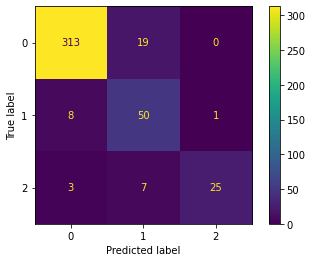

In [43]:
ConfusionMatrixDisplay.from_predictions(test_trues, test_preds)

plt.show()

In [44]:
print(classification_report(test_trues, test_preds,zero_division=1))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95       332
           1       0.66      0.85      0.74        59
           2       0.96      0.71      0.82        35

    accuracy                           0.91       426
   macro avg       0.86      0.83      0.84       426
weighted avg       0.92      0.91      0.91       426



In [45]:
testloss

tensor(0.6466)

In [46]:
print(accuracy_score(test_trues, test_preds))

0.9107981220657277


In [47]:
 print("Loss score is: ", log_loss(test_data_label,probs))

Loss score is:  0.4220331533076809


In [48]:
execution_time_ann

'2.6988'

In [49]:
ann_accuracy='%.4f'% accuracy_score(test_trues, test_preds)
# 0.7386

In [50]:
ann_f1='%.4f'% f1_score(test_trues, test_preds, average='micro')

In [51]:
ann_roc_auc='%.4f'% roc_auc_score(test_data_label,probs,multi_class='ovr')

In [52]:
ann_loss='%.4f'% testloss

In [53]:
ann_roc_auc

'0.9569'

In [54]:
log_loss(test_data_label,probs)

0.4220331533076809

In [55]:
CTGNSP_dict = { 
              'accuracy':[lgbm_accuracy,svc_accuracy0,rf_accuracy,ann_accuracy],
               'f1_score': [lgbm_f1,svc_f10,rf_f1,ann_f1],
               'roc_auc': [lgbm_roc_auc,svc_roc_auc0,rf_roc_auc,ann_roc_auc],
               'cross_entropy_loss': [lgbm_loss,svc_loss0,rf_loss,ann_loss],
                'training_time[s]':[training_time_lgbm,training_time_svm,training_time_rf,execution_time_ann ]
               }
pr_df_ctgnsp = pd.DataFrame(CTGNSP_dict,index=['Light GBM','SVM','Random Forest','PyTorch ANN'])
pr_df_ctgnsp

,accuracy,f1_score,roc_auc,cross_entropy_loss,training_time[s]
Light GBM,0.9319,0.9319,0.9825,0.1832,0.6258
SVM,0.9225,0.9225,0.9739,0.2152,0.2375
Random Forest,0.9390,0.9390,0.9833,0.1816,0.2514
PyTorch ANN,0.9108,0.9108,0.9569,0.6466,2.6988


In [56]:
pr_df_ctgnsp.to_csv('CTGNSP Score.csv')